In [19]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [1]:
import numpy as np
from scipy.sparse import csr_array, lil_array
import matplotlib.pyplot as plt
import pandas as pd
import math
import pickle
import time
import datetime
import random
from pprint import pprint
from lightgbm import LGBMRanker
from sklearn.model_selection import train_test_split

from SVD import Metrics, SVDPredictor, LogisticSVD, FastLogisticSVD
from RecData import RecData

In [2]:
# recs = pd.read_csv('data/recommendations.csv')
recs = pd.read_csv('data/pruned.csv')
# recs = pd.read_csv('data/2plus.csv')

# Remove old ratings
recs = recs.sort_values(by=['date'], ascending=False)
recs.drop_duplicates(subset= ['app_id', 'user_id'], inplace=True) 

USED_COLS = ['app_id', 'is_recommended', 'user_id']
recs = recs[USED_COLS]

item_data = pd.read_csv('data/games.csv')
titles = item_data[['app_id', 'title']]

print("Shape:", recs.shape)
recs.sort_values(by=['user_id', 'app_id']).head()

Shape: (1482532, 3)


,app_id,is_recommended,user_id
629351,12210,True,240
116928,22380,True,240
1418125,239140,True,240
236273,251570,True,240
87206,270880,True,240


In [3]:
random.seed(42)
np.random.seed(42)

rec_data = RecData()
rec_data.create_from_dataframe(recs)
rec_data.set_titles(titles)

# del recs

start_time = time.time()
print("Creating splits...")
train_data, test = rec_data.train_test_split(test_size=0.2)
print("First split done.")
train_data, val = train_data.train_test_split(test_size=0.2)
print("Done creating splits in", time.time() - start_time, "seconds")

Creating utility matrix...
Done utility matrix.
Creating splits...
First split done.
Done creating splits in 4.368761301040649 seconds


In [4]:
df = rec_data.generate_dataframe()
df.sort_values(by=['user_id', 'app_id']).head()

,app_id,is_recommended,user_id
1227091,12210,1.0,240
1227100,22380,1.0,240
1227099,239140,1.0,240
1227101,251570,1.0,240
1227087,270880,1.0,240


In [5]:
# random.seed(42)
# np.random.seed(42)

# rec_data = RecData()
# rec_data.create_from_dataframe(recs)
# rec_data.set_titles(titles)

# del recs

# print("Creating splits...")
# train_data, val, test = rec_data.leave_k_out_split(k=1)
# print("Done creating splits.")

In [6]:
del rec_data
del item_data
del titles

In [12]:
train = train_data.generate_dataframe()
X_train = train[['app_id', 'user_id']]
y_train = train['is_recommended'].to_numpy()

X_train = X_train.sort_values(by='user_id')
counts = X_train['user_id'].value_counts(sort=False)

In [ ]:
ranker = LGBMRanker(random_state=42, objective='lambdarank')
ranker = ranker.fit(X_train, y_train, group = counts.values, 
                    eval_set=[(X_train, y_train)], eval_group=[counts.values], 
                    eval_at=20)

Epoch 0/Training error: 0.6931285422628719/Validation error: 0.6931471311072868/Time: 5.44 seconds
Epoch 1/Training error: 0.69311534280527/Validation error: 0.6931466312604546/Time: 3.32 seconds
Epoch 2/Training error: 0.6931022713238413/Validation error: 0.693144775127245/Time: 3.35 seconds
Epoch 3/Training error: 0.6930859231425883/Validation error: 0.6931399353297277/Time: 3.49 seconds
Epoch 4/Training error: 0.6930601264320715/Validation error: 0.6931273011669671/Time: 3.35 seconds


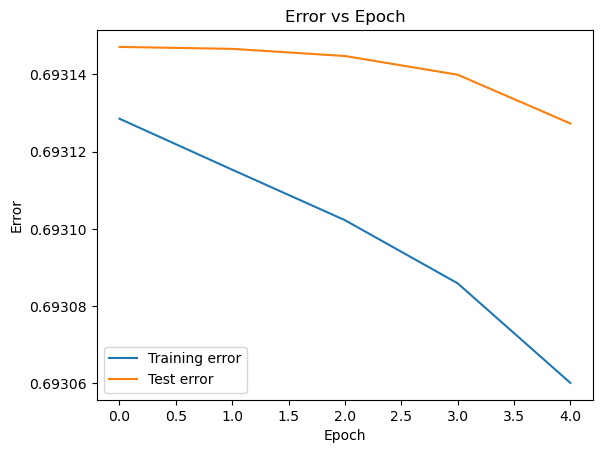

Test rmse 0.49999006020541087


In [7]:
# for pruned, epoch: 30, lr:0.01, reg:0.02

EPOCHS = 5

random.seed(42)
np.random.seed(42)

# Fit and predict with svd
svd_predictor = FastLogisticSVD(
    train_data.get_num_users(), train_data.get_num_items(), 2, k=50, 
    learning_rate=0.01, C=0.02)
svd_predictor.fit(train_data.get_matrix(), EPOCHS, validation_set=val, early_stop=False)

# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Test rmse", rmse)

In [30]:
svd_predictor.continue_fit(10, early_stop=False)

Epoch 0/Training error: 0.3649113275987332/Validation error: 0.48049979437117424/Time: 25.99 seconds
Epoch 1/Training error: 0.35930834401695533/Validation error: 0.47776283145943016/Time: 26.34 seconds
Epoch 2/Training error: 0.35418723614712394/Validation error: 0.4753436418017298/Time: 26.17 seconds
Epoch 3/Training error: 0.34933950703437183/Validation error: 0.4730380656928443/Time: 26.24 seconds
Epoch 4/Training error: 0.3446066484524097/Validation error: 0.4709855276799591/Time: 26.14 seconds
Epoch 5/Training error: 0.34039625957499503/Validation error: 0.4691506163302096/Time: 26.15 seconds
Epoch 6/Training error: 0.3358584877630693/Validation error: 0.46731418809258607/Time: 26.21 seconds
Epoch 7/Training error: 0.33165269794376157/Validation error: 0.46574584519353374/Time: 26.08 seconds
Epoch 8/Training error: 0.3277492026143433/Validation error: 0.4642444601854805/Time: 26.16 seconds
Epoch 9/Training error: 0.3238179689212575/Validation error: 0.4628893504387243/Time: 37.79

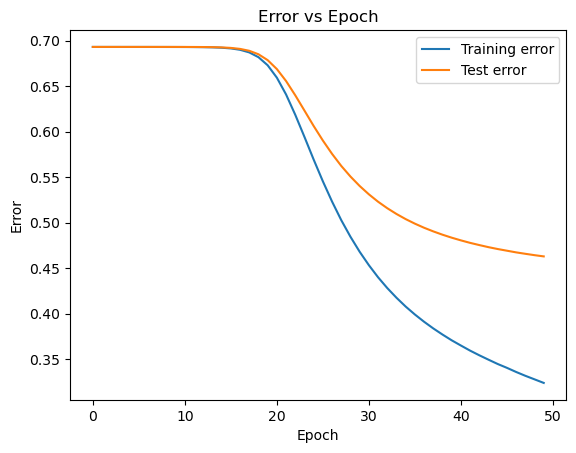

Test rmse 0.3849944608953721


In [32]:
# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Test rmse", rmse)

In [ ]:
svd_predictor.compute_sims()

In [17]:
# Ensure file exists
model_dir = model_dir = "saved_models/{}-{}-{}-{}-{}-{}_{}".format(
    *(time.localtime()[:6] + (round(rmse, 4), ))).replace(".", "-") + ".pkl" 
file = open(model_dir, 'a')
file.close()

# Save model
print("Saving model...")
with open(model_dir, 'wb') as file:
    pickle.dump([train_data, svd_predictor], file)
print("Done saving model.")

Saving model...
Done saving model.


## Tests

In [ ]:
with open('model.pkl', 'rb') as file:
    data, svd_predictor = pickle.load(file)

In [ ]:
svd_predictor.items_top_n([(341, 1), (612, 1)])

In [ ]:
start_time = time.time()
print("Computing recall...")
svd_predictor.compute_recall(val)
print("Done computing recall in", time.time() - start_time, "seconds")

In [44]:
top = svd_predictor.items_knn([(293, 1)])
pprint([(sim, train_data.index_to_title(index)) for sim, index in top])

[(0.9934836598178022, 'Left 4 Dead 2'),
 (0.9932750433266724, 'Papers Please'),
 (0.9930878320501089, 'Counter-Strike: Source'),
 (0.9930248652087343, 'Call of Duty®: Modern Warfare® 2 (2009)'),
 (0.992819952562889, 'Wallpaper Engine'),
 (0.992537910651242, 'Terraria'),
 (0.9925366695440154, 'Portal 2'),
 (0.9925135890009634, 'Portal'),
 (0.9923979768022965, 'Euro Truck Simulator 2'),
 (0.9922682975023462, "Garry's Mod")]


In [35]:
j = 1

# Test top-n list for user j
top_n = svd_predictor.top_n(j, 20)
print("Predicted top n:")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])

# User j true top n list
print("True top n:")
true_top = train_data.top_n(j, 5000)
pprint([train_data.index_to_title(index) for _, index in true_top])

Predicted top n:
[(0.9206996135928255, 'Terraria'),
 (0.9184847026535525, 'Wallpaper Engine'),
 (0.9184279431494676, 'Wobbly Life'),
 (0.9181253755759784, 'BeamNG.drive'),
 (0.917575966622757, 'PowerWash Simulator'),
 (0.9174844142901013, 'CarX Drift Racing Online'),
 (0.9173332188422043, "Garry's Mod"),
 (0.9172366163661728, 'American Truck Simulator'),
 (0.9171008246042601, 'MX Bikes'),
 (0.9169435575423818, 'OMORI'),
 (0.9167840714944547, 'Clone Drone in the Danger Zone'),
 (0.916729938216813, 'ULTRAKILL'),
 (0.91655451691545, 'Bloons TD 6'),
 (0.9163327476250769, 'The Test'),
 (0.9161519525318034, 'Stray'),
 (0.9159680183399378, 'The Binding of Isaac: Rebirth'),
 (0.9159476161516685, 'PlateUp!'),
 (0.9159294076641218, 'Slay the Spire'),
 (0.9158426163539647, 'Walkabout Mini Golf VR'),
 (0.9157920999863275, 'Portal 2')]
True top n:
['Detroit: Become Human', 'Vampire Survivors', 'Borderlands 3', 'Left 4 Dead 2']


In [ ]:
# values, bins = np.histogram(svd_predictor._user_features[0, :])
# plt.stairs(values, bins)
# plt.show()

In [9]:
train_data.search_title('forza')

[('Forza Horizon 4', 341), ('Forza Horizon 5', 286)]

In [87]:
prefs = [(196, 0), (740, 1), (174, 1), (819, 1)]
# prefs = [(5, 1), (229, 1), (966, 0)]
pprint([(index, train_data.index_to_title(index), pref) for index, pref in prefs])
prefs = train_data.create_prefs(prefs)    

[(196, 'Mortal Kombat X', 0),
 (740, 'The Sims™ 3', 1),
 (174, 'The Sims™ 4', 1),
 (819, 'A Hat in Time', 1)]


In [ ]:
start_time = time.time()
svd_predictor.partial_fit(prefs, epochs=EPOCHS)
print("Completed partial fit in", time.time() - start_time, "seconds")

In [ ]:
top_n = svd_predictor.top_n(svd_predictor._num_users - 1, 20)
print("Predicted top n")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])